# <font color='blue'> <center> Deep SARSA </center> </font>

In this notebook, we extend the SARSA algorithm to use function approximators (Neural Networks). The resulting algorithm is known as Deep SARSA.

## <font color='#2874A6'> Table of Contents </font>

1. [Modules](#1)
2. [Setup Code](#2)
3. [Algorithm](#3)
4. [Results](#4)

<a name="1"></a>
## <font color='#0E6655'> 1. Modules </font> 

In [1]:
#!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw

import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

%matplotlib notebook

<a name="2"></a>
## <font color='#0E6655'> 2. Setup Code </font> 

In [2]:
class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(10, 5))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def plot_cost_to_go(env, q_network, xlabel=None, ylabel=None):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)

    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = - q_network(q_net_input).max(dim=-1, keepdim=True)[0]
    Z = Z.reshape(100, 100).detach().numpy()
    X = X.numpy()
    Y = Y.numpy()

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet', linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)
    ax.set_title("Estimated cost-to-go", size=18)
    plt.tight_layout()
    plt.show()


def plot_max_q(env, q_network, xlabel=None, ylabel=None, action_labels=[]):
    highx, highy = env.observation_space.high
    lowx, lowy = env.observation_space.low
    X = torch.linspace(lowx, highx, 100)
    Y = torch.linspace(lowy, highy, 100)
    X, Y = torch.meshgrid(X, Y)
    q_net_input = torch.stack([X.flatten(), Y.flatten()], dim=-1)
    Z = q_network(q_net_input).argmax(dim=-1, keepdim=True)
    Z = Z.reshape(100, 100).T.detach().numpy()
    values = np.unique(Z.ravel())
    values.sort()

    plt.figure(figsize=(5, 5))
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.title("Optimal action", size=18)

    im = plt.imshow(Z, cmap='jet')
    colors = [im.cmap(im.norm(value)) for value in values]
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, action_labels)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


<a name="3"></a>
## <font color='#0E6655'> 3. Algorithm </font> 

### Create and prepare the environment

#### Create the environment

In [3]:
env = gym.make('MountainCar-v0')
seed_everything(env)

In [4]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"MountainCar env: State dimensions: {state_dims}, Number of actions: {num_actions}")

MountainCar env: State dimensions: 2, Number of actions: 3


estado: pos. y velocidad; acciones: no moverse o ir a un lado

#### Prepare the environment to work with PyTorch

In [5]:
# será un wrapper alrededor del entorno


class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

            
    def reset(self):
        obs = self.env.reset() # obtiene del entorno el resultado de ejecutar reset;
            # que es un array de numpy; debo convertirla a un tensor
        
        # convierto a tensor y cambio la forma
        # dsp. de from_numpy queda algo como [0. 0.] (observaciones sueltas) 
        # y quiero [[0. 0.], [1. 1.]] pues voy a trabajar con lotes
        # con unsqueeze creo una dimensión extra en el lugar 0
        return torch.from_numpy(obs).unsqueeze(dim=0).float()

    
    
    def step(self, action):
        action = action.item() # convierto la acción a un entero
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float() # convierto a tensores
            # y los preparo para trabajar con lotes
        reward = torch.tensor(reward).view(1, -1).float() # convierto a tensor
        done = torch.tensor(done).view(1, -1) # cambio la forma para que quede por ej. [[0.]]
        return next_state, reward, done, info

In [6]:
env = PreprocessEnv(env)

In [7]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[-0.4452,  0.0000]])
Next state: tensor([[-0.4468, -0.0016]]), Reward: tensor([[-1.]]), Done: tensor([[False]])


### Create the Q-Network and policy

#### Create the Q-Network: $\hat q(s,a| \theta)$

In [8]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions))

#### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

Creamos una copia de la red neuronal que vamos a utilizar para estimar los q-valores. Esta red tendrá sus params. congelados.

In [9]:
target_q_network = copy.deepcopy(q_network).eval() # el eval es para que no cambie
    # hará que la red no modifique sus params. cuando apliquemos backpropaga

#### Create the $\epsilon$-greedy policy: $\pi(s)$

In [10]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

#### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

costo de llegar a la meta desde ese estado

/home/marcos/.local/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


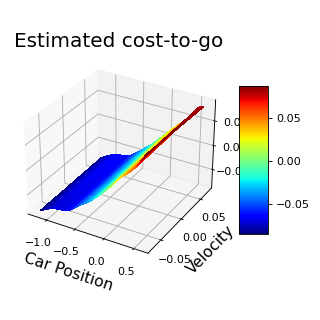

In [11]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

como la red fue inicializada aleatoriamente, las predicciones no son precisas, pero mejoraremos

### Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>


Aquí guardarmemos las transiciones de estado.

<img src="images/replay buffer.png"/>


In [14]:
class ReplayMemory:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # insertar una transición de estado en la memoria: [s, a, r, s']
    def insert(self, transition):
        # si hay capacidad abro un hueco; sino sobrescribiré
        if len(self.memory) < self.capacity:
            self.memory.append(None) 
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity # el % por si llegué al final
                # para volver a la primer posición

    # sacar un lote de la memoria con transiciones de estado: ej: [[s,a,r,s'], [s2, a2, r2, s'2]]
    # nos permitirá actualizar la red neuronal
    def sample(self, batch_size):
        assert self.can_sample(batch_size) # para saber si podemos sacar el lote

        batch = random.sample(self.memory, batch_size) # escojo de la memoria
                # una cantidad igual a batch size al azar
            
            
        # ahora tenemos una lista de transiciones:
        # ej: [[s,a,r,s'], [s2, a2, r2, s'2]], pero queremos
        # [ [s, s2  ..], [a, a2 ..], [r, r2 .. ], [s' , s'2 ..] ]
            
        batch = zip(*batch)
        
        # convertimos cada elemento en un tensor y lo guardamos en una lista
        # cat concatena elementos
        return [torch.cat(items) for items in batch]

    # si la memoria tiene suficientes transiciones de estado como para sacar de ella lotes para aprender
    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10 # critero: que lo que haya en la memoria
                # sea al menos 10 veces mayor que el lote

    # cantidad de elementos
    def __len__(self):
        return len(self.memory)

### Implement the algorithm

<img src="images/algorithm.png"/>


In [15]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001,
               batch_size=32, gamma=0.99, epsilon=0.05):
    
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []} # para las estadísticas del proceso de aprendizaje

    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0 # suma las recompensas para calcular el retorno de cada episodio
        
        while not done:
            
            action = policy(state, epsilon) # escogemos la acción
            next_state, reward, done, _ = env.step(action) # ehjecutamos la acción en el entorno
            memory.insert([state, action, reward, done, next_state]) # guardamos la transición en la memoria

            if memory.can_sample(batch_size):
                
                # generamos un lote; sacamos los datos de la memoria
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                
                # estimamos el q-valor del par estado-acción
                # q_network(state_b) nos da los q-valores para todas las acciones
                # con gather obtenemos de cada fila el q-valor de la acción que escogimos
                qsa_b = q_network(state_b).gather(1, action_b)
                
                # escogemos la siguiente acción
                next_action_b = policy(next_state_b, epsilon)
                
                # q-valor del target; aquí usamos la copia de la red neuronal
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                
                # calculamos el target
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                
                # optimización
                loss = F.mse_loss(qsa_b, target_b)
                
                q_network.zero_grad()
                
                loss.backward()
                
                optim.step()
                
                # agrego a las estadísticas
                stats['MSE Loss'].append(loss.item())

            # actualizamos el estado
            state = next_state
            
            # actualizamos el retorno del episodio
            ep_return += reward.item()
        
        # al finalizar el episodio guardamos su valor
        stats['Returns'].append(ep_return)

        # cada cierto número de episodios, actualizamos la red target (cada 10 en este ejemplo)
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
                # state_dict() guarda el estado interno de una red neuronal

    return stats

In [16]:
stats = deep_sarsa(q_network, policy, 1500, epsilon=0.01) #2500

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [10:17<00:00,  2.43it/s]


<a name="4"></a>
## <font color='#0E6655'> 4. Results </font> 

### Plot execution stats

<IPython.core.display.Javascript object>


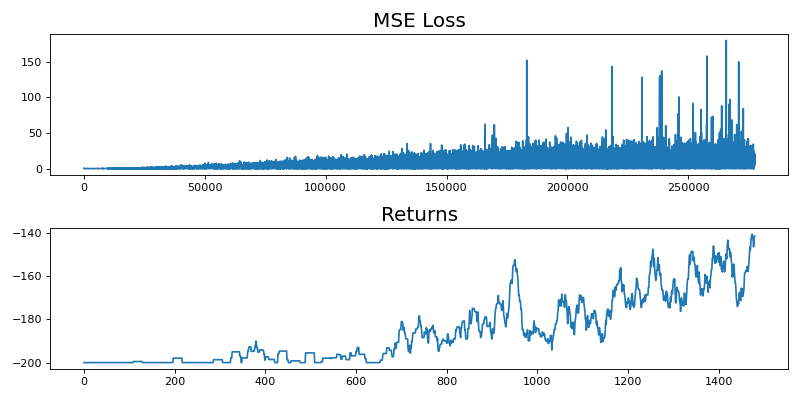

In [17]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

<IPython.core.display.Javascript object>


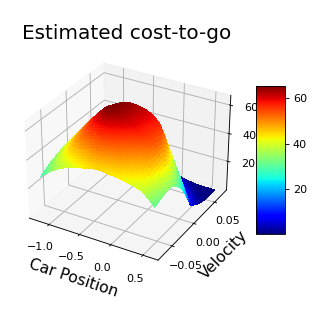

In [18]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

### Show resulting policy: $\pi(s)$

<IPython.core.display.Javascript object>


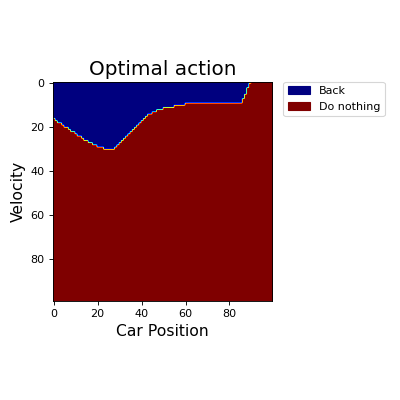

In [19]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Velocity',
           action_labels=['Back', 'Do nothing', 'Forward'])

### Test the resulting agent

In [ ]:
test_agent(env, policy, episodes=2)

<a name="5"></a>
## <font color='#0E6655'> 5. Annex </font> 

In [15]:
a = np.array([1])
a

array([1])

In [14]:
torch.from_numpy(a)

tensor([1])

In [16]:
torch.from_numpy(a).unsqueeze(dim=0)

tensor([[1]])

In [18]:
torch.tensor(a).view(1, -1)

tensor([[1]])

In [19]:
torch.tensor(np.array([1, 7])).view(1, -1)

tensor([[1, 7]])